In [1]:
import os
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:58591'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:58591'

%matplotlib inline

In [2]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

from scipy import interpolate
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [3]:
ee.Initialize()

### Get the pixel count 

In [13]:
# get the urban img
urban = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")
region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

# mask out 0-value pixels
urban = urban.mask(urban.gte(1))

# get the pixel count of each year
urban_pix_count = urban.reduceRegion(reducer = ee.Reducer.frequencyHistogram(),
                                    geometry = region.geometry().convexHull(),
                                    scale = 30,
                                    maxPixels = int(1e13)).getInfo()['b1']

In [4]:
# define the pixel value that corespondind to the year
true_image_year_val = {f'{i+1}':f'{year}_{year+2}' for (i,year) in enumerate(range(2017,1989,-3))}


# get the urban growth-pixels count
pix_count_df = pd.DataFrame({true_image_year_val[str(i)]:[urban_pix_count[str(i)]] for i in range(10,0,-1)}).T

# accumulate the growth-pixels, then make the middle year as the date
pix_count_df['pix_count'] = pix_count_df[0].cumsum()
pix_count_df['year'] = range(1991,2019,3)
pix_count_df = pix_count_df[['year','pix_count']]
pix_count_df['area_km2'] = pix_count_df['pix_count']*30*30/1000/1000

In [5]:
# save data to disk
pix_count_df.to_csv('../Data/Result_csv/pix_count_df.csv',index=False)
pix_count_df = pd.read_csv('../Data/Result_csv/pix_count_df.csv')
pix_count_df

,year,pix_count,area_km2
0,1991,4.216937e+07,37952.428634
1,1994,5.361226e+07,48251.037734
2,1997,6.109841e+07,54988.567334
3,2000,6.681810e+07,60136.292834
4,2003,7.495013e+07,67455.119478
5,2006,8.480370e+07,76323.327212
6,2009,9.700969e+07,87308.719112
7,2012,1.109729e+08,99875.573912
8,2015,1.259419e+08,113347.685054
9,2018,1.464770e+08,131829.274264


### Exponetial fitting to predict to 2030

In [50]:
# get value for fiting
X = pix_count_df['year']
y = pix_count_df['pix_count']

ext_range = range(1991,2031,3)


# fit the urban pixel count, note the p0 were created from additional Excel Trend Line
coef,_ = curve_fit(lambda t,a,b: a*np.exp(b*t), X, y, p0=[1e-30,0.04])

# get the coefficients
fit_val = coef[0]*np.exp(coef[1]*pix_count_df['year'])
fit_val_ext = coef[0]*np.exp(coef[1]*ext_range)

# compute the R2
R2 = r2_score(y,fit_val)
R2

C:\ProgramData\Anaconda3\envs\python37\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.9970720928221682

In [56]:
coef

array([1.61005976e-30, 4.33059036e-02])

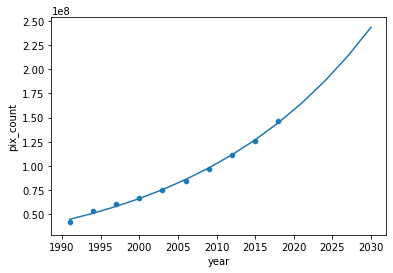

In [51]:
sns.lineplot(x=ext_range,y=fit_val_ext)
sns.scatterplot(x=X,y=y)

In [54]:
fit_ext_tf = pd.DataFrame(data={'year':ext_range,'pix_count':fit_val_ext})
fit_ext_tf['area_km2'] = fit_ext_tf['pix_count']*30*30/1000/1000
fit_ext_tf

,year,pix_count,area_km2
0,1991,4.493703e+07,40443.323991
1,1994,5.117135e+07,46054.215362
2,1997,5.827059e+07,52443.531919
3,2000,6.635474e+07,59719.268226
4,2003,7.556045e+07,68004.401437
5,2006,8.604330e+07,77438.969904
6,2009,9.798049e+07,88182.440152
7,2012,1.115738e+08,100416.402243
8,2015,1.270529e+08,114347.639078
9,2018,1.446796e+08,130211.621513


In [55]:
# save data to disk
fit_ext_tf.to_csv('../Data/Result_csv/fit_ext_tf.csv',index=False)
fit_ext_tf = pd.read_csv('../Data/Result_csv/fit_ext_tf.csv')
fit_ext_tf

,year,pix_count,area_km2
0,1991,4.493703e+07,40443.323991
1,1994,5.117135e+07,46054.215362
2,1997,5.827059e+07,52443.531919
3,2000,6.635474e+07,59719.268226
4,2003,7.556045e+07,68004.401437
5,2006,8.604330e+07,77438.969904
6,2009,9.798049e+07,88182.440152
7,2012,1.115738e+08,100416.402243
8,2015,1.270529e+08,114347.639078
9,2018,1.446796e+08,130211.621513


##### Predicted areas of each region

In [4]:
# get the maps 
urban_2017_2019 = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward").gte(1)
pred_2030 = ee.Image("users/wangjinzhulala/GEE_TF/Urban_projection/Proj_to_future_2017_2019_to_2030")

# get city boundaries
region_province = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

In [5]:
# get stats
urban_2017_2019_stats = urban_2017_2019.reduceRegions(reducer = ee.Reducer.sum(),
                                            collection = region_province,
                                            scale = 30).getInfo()

pred_2030_stats = pred_2030.reduceRegions(reducer = ee.Reducer.sum(),
                                            collection = region_province,
                                            scale = 30).getInfo()


In [25]:
pred_df = pd.DataFrame([(i['properties']['NAME'],i['properties']['sum']*30*30/1000/1000) for i in urban_2017_2019_stats['features']])
pred_df['2030'] = [i['properties']['sum']*30*30/1000/1000 for i in pred_2030_stats['features']]
pred_df['Percent increase'] = (pred_df['2030'] - pred_df[1])/pred_df['2030'] * 100
pred_df.columns = ['Region','2017_2019','2030','Percent increase']
pred_df['Region'] = ['Shandong','Henan','Beijing','Tianjin','Hebei','Anhui','Jiangsu']
pred_df.sort_values('Region',inplace=True)
pred_df.to_csv('../Data/Result_csv/pred_2030_areas.csv',index=False)

In [26]:
pred_df = pd.read_csv('../Data/Result_csv/pred_2030_areas.csv',encoding='utf-8-sig')
pred_df

,Region,2017_2019,2030,Percent increase
0,Anhui,21070.963736,29463.606519,28.484778
1,Beijing,2630.092486,3338.754611,21.225343
2,Hebei,20454.292786,26440.377854,22.639938
3,Henan,28282.244456,38850.765131,27.202864
4,Jiangsu,24210.079772,33731.720749,28.227558
5,Shandong,32005.141602,42758.606058,25.149240
6,Tianjin,2925.680241,3754.646407,22.078408
